## Dataset (k2h2w) Overview

In [1]:
%reload_ext autoreload
%autoreload 2

In [6]:
DATASET_ID = "k2h2w"

In [2]:
from collections import defaultdict
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
import sys
sys.path.append('../../')

from tsdr import tsdr
from eval import groundtruth
from meltria import loader

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
metrics_files = !find "/datasets/argowf-chaos-{DATASET_ID}/" -type f -name "*.json"
dataset_generator = loader.load_dataset_as_generator(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=180,
)
records = [r for rec in dataset_generator for r in rec]

In [7]:
record_and_reduced_df: list = []
for record in records:
    # run tsdr
    reducer = tsdr.Tsdr("residual_integral", **{
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 2,
        "step2_dbscan_dist_type": 'sbd',
        "step2_dbscan_algorithm": 'hdbscan',
        "step2_clustering_series_type": 'raw',
        "step2_clustering_choice_method": 'medoid',
    })
    tsdr_stat, clustering_info, anomaly_points = reducer.run(
        X=record.data_df,
        pk=record.pk,
        max_workers=cpu_count(),
    )
    reduced_df = tsdr_stat[-1][0]
    no_clustering_reduced_df = tsdr_stat[-2][0]
    record_and_reduced_df.append((record, reduced_df, no_clustering_reduced_df))

In [8]:
import pickle
import glob
import pathlib


def save_tsdr(record, reduced_df, no_clustering_reduced_df):
    path = pathlib.Path(f"../data/tsdr_{DATASET_ID}/{record.chaos_case_full().replace('/', '_')}")
    path.mkdir()
    for obj, name in ((record, "record"), (reduced_df, "reduced_df"), (no_clustering_reduced_df, "no_clustering_reduced_df")):
        with open(path / f"{name}.pkl", "wb") as f:
            pickle.dump(obj, f)

def load_tsdr():
    results = []
    parent_path = pathlib.Path(f"../data/tsdr_{DATASET_ID}")
    parent_path.mkdir(exist_ok=True)
    for path in parent_path.iterdir():
        with (path / "record.pkl").open("rb") as f:
            record = pickle.load(f)
        with (path / "reduced_df.pkl").open("rb") as f:
            reduced_df = pickle.load(f)
        with (path / "no_clustering_reduced_df.pkl").open("rb") as f:
            no_clustering_reduced_df = pickle.load(f)
        results.append((record, reduced_df, no_clustering_reduced_df))
    return results

In [10]:
for record, reduced_df, no_clustering_reduced_df in record_and_reduced_df:
    save_tsdr(record, reduced_df, no_clustering_reduced_df)

In [11]:
datasets_after_tsdr = load_tsdr()

KeyError: 's-ts-ui-dashboard_requests_errors_count'

<Figure size 2000x5000 with 0 Axes>

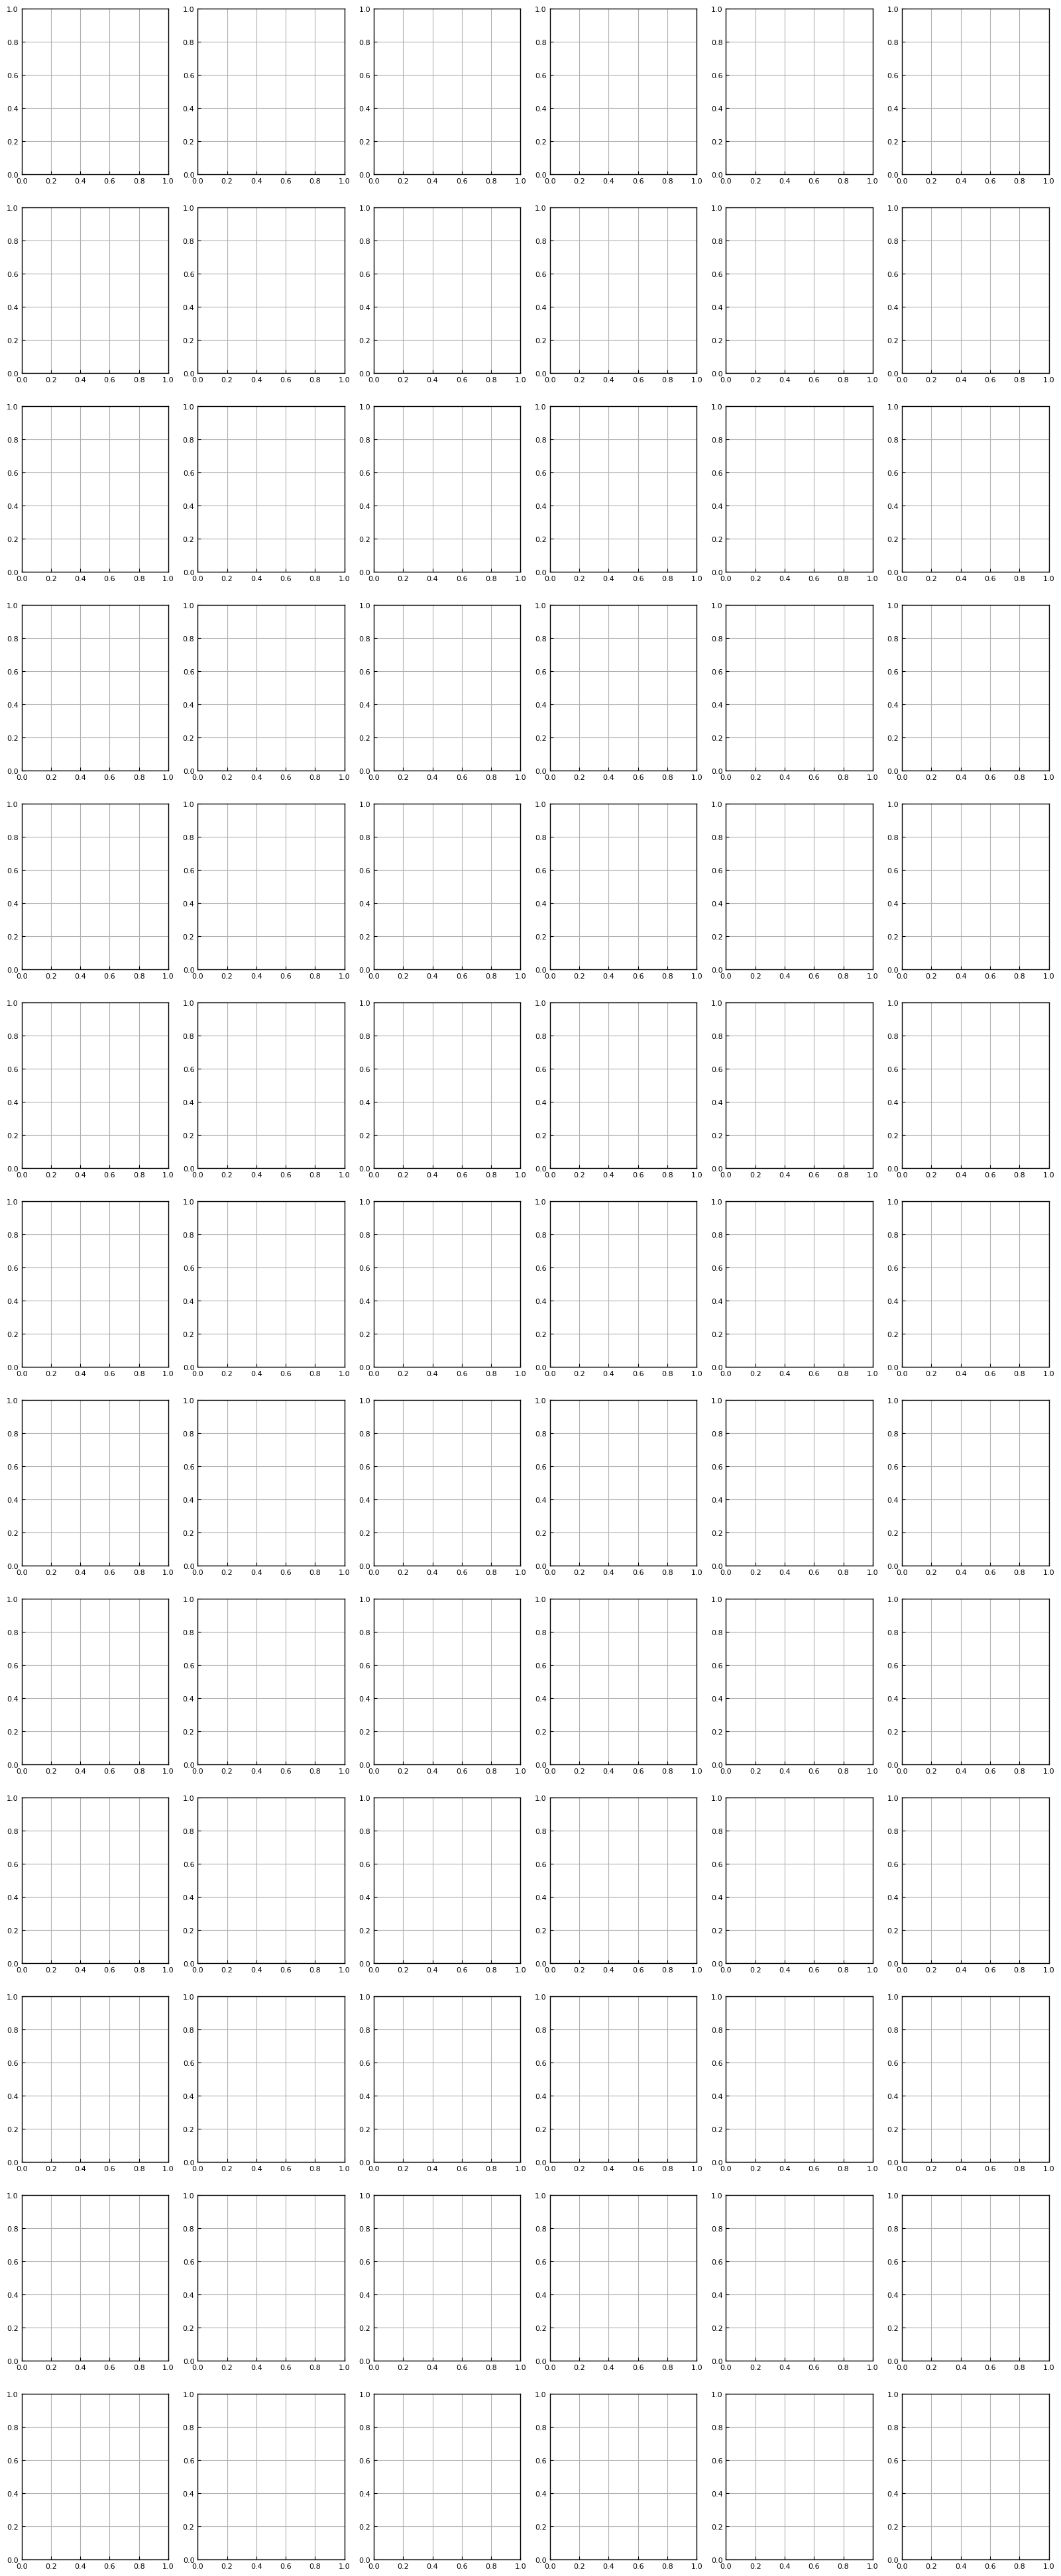

In [23]:
import math

slis_fig = plt.figure(figsize=(20, 50))
slis_fig, slis_axs = plt.subplots(math.ceil(len(datasets_after_tsdr)/6), 6, figsize=(20, 50))
for i, (slis_ax, (record, _, _)) in enumerate(zip(slis_axs.flatten(), datasets_after_tsdr)):
    sli_name = record.pk.get_root_metrics()[0]
    slis_ax.plot(record.data_df[sli_name].to_numpy()[60:])
    title = f"{i+1}: {record.chaos_case_full()}"
    slis_ax.set_title(title)
    print(title)